# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [1]:
from fastai.vision import *
!pip install split-folders

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Get a list of images

In [3]:
from pathlib import Path
from fastai.vision import *
from fastai.metrics import error_rate
path = Path.cwd()/'drive/My Drive/imagesConverted'
print(path)
path.ls()

/content/drive/My Drive/imagesConverted


[PosixPath('/content/drive/My Drive/imagesConverted/train'),
 PosixPath('/content/drive/My Drive/imagesConverted/val'),
 PosixPath('/content/drive/My Drive/imagesConverted/test'),
 PosixPath('/content/drive/My Drive/imagesConverted/export.pkl'),
 PosixPath('/content/drive/My Drive/imagesConverted/models')]

In [0]:
# DO NOT RUN
# ----------------------
#
#
#
#
#
#
#
#
#
import split_folders
path = Path.cwd()/'drive/My Drive/images'
split_folders.ratio(path, output=Path.cwd()/'drive/My Drive/imagesConverted', seed=1337, ratio=(.8, .1, .1))

# ----------------------

In [0]:
src = (ImageList.from_folder(path)
        .split_by_folder('train', 'val')
        .label_from_folder()
        .add_test_folder())

In [5]:
print(src)

LabelLists;

Train: LabelList (2153 items)
x: ImageList
Image (3, 480, 852),Image (3, 600, 800),Image (3, 427, 1024),Image (3, 600, 600),Image (3, 767, 512)
y: CategoryList
grand piano,grand piano,grand piano,grand piano,grand piano
Path: /content/drive/My Drive/imagesConverted;

Valid: LabelList (287 items)
x: ImageList
Image (3, 590, 590),Image (3, 500, 500),Image (3, 350, 350),Image (3, 405, 450),Image (3, 640, 960)
y: CategoryList
grand piano,grand piano,grand piano,grand piano,grand piano
Path: /content/drive/My Drive/imagesConverted;

Test: LabelList (286 items)
x: ImageList
Image (3, 467, 700),Image (3, 507, 1022),Image (3, 869, 800),Image (3, 374, 500),Image (3, 360, 480)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/imagesConverted


In [0]:
# hide all warnings because I was annoyed by it
import warnings
warnings.filterwarnings(action='ignore')

In [0]:
data = (src.transform(get_transforms(), size=256)
        .databunch())

In [0]:
data.classes

['clarinet', 'drums', 'grand piano', 'guitar', 'saxophone', 'trumpet']

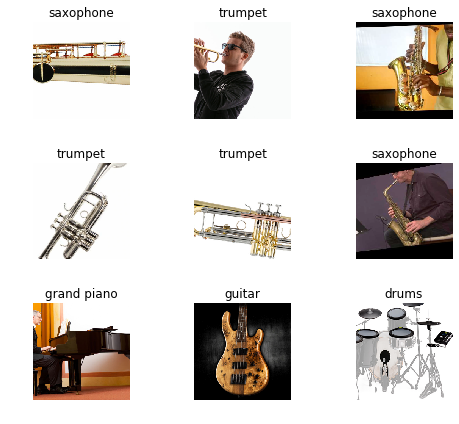

In [0]:
data.show_batch(rows=3, figsize=(7,6))

You will need to run this cell once per each category.

## View data

Good! Let's take a look at some of our pictures then.

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['clarinet', 'drums', 'grand piano', 'guitar', 'saxophone', 'trumpet'],
 6,
 2153,
 287)

## Train model

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 87.5MB/s]


In [9]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.560723,0.120635,0.034843,07:03


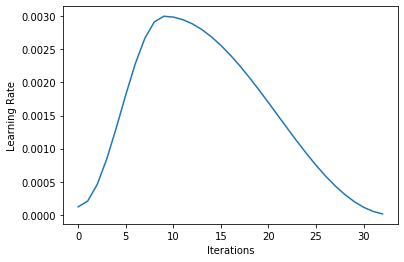

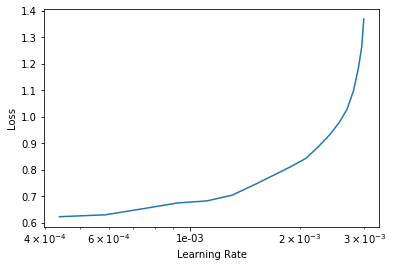

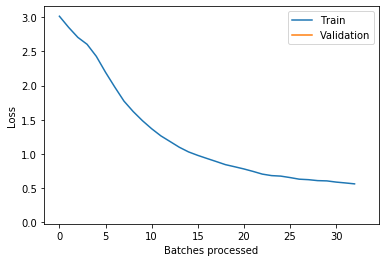

In [10]:
learn.recorder.plot_lr()
learn.recorder.plot()
learn.recorder.plot_losses()

In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


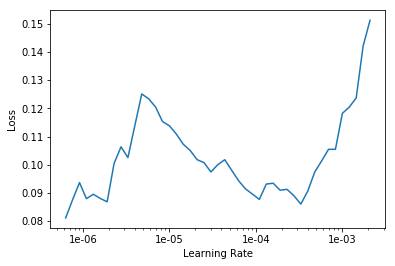

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-045,1e-035))

epoch,train_loss,valid_loss,error_rate,time
0,0.164175,0.237468,0.066202,01:10
1,0.132675,0.184647,0.034843,01:09


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

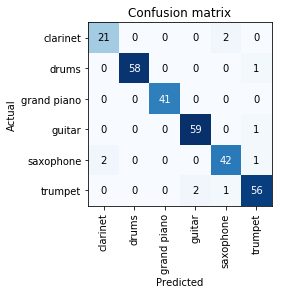

In [0]:
interp.plot_confusion_matrix()

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [0]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



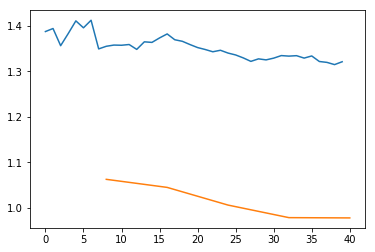

In [0]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [0]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [0]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2